### Example

# RRCF-Power

## Import and Reshape Data

In [1]:
import pandas as pd
df_raw = pd.read_csv('rrcf_power/data/sample-1H.csv')
df_raw.head()

,Unnamed: 0,date,category,value
0,1,2019-09-01 12:00:00,A,17
1,2,2019-09-01 12:00:00,B,6
2,3,2019-09-01 12:00:00,C,7
3,4,2019-09-01 13:00:00,A,23
4,5,2019-09-01 13:00:00,B,1


In [2]:
df_raw['date'] = pd.to_datetime(df_raw['date'])

In [3]:
df_currated = df_raw.copy()
df_currated.drop_duplicates(subset=['date'], inplace=True)
df_currated.set_index('date', inplace=True)
df_currated.head()

,Unnamed: 0,category,value
date,,,
2019-09-01 12:00:00,1,A,17
2019-09-01 13:00:00,4,A,23
2019-09-01 14:00:00,7,A,17
2019-09-01 15:00:00,10,A,15
2019-09-01 16:00:00,13,A,15


In [4]:
for category, col_name in zip(['A', 'B', 'C'], ['unit_a', 'unit_b', 'unit_c']):
    df_temp = df_raw[df_raw['category']==category].copy()
    df_temp.drop_duplicates(subset=['date'], inplace=True)
    df_temp.set_index('date', inplace=True)
    df_temp.drop(['category', 'Unnamed: 0'], axis=1, inplace=True)
    df_temp.rename(columns={'value':col_name}, inplace=True)
    df_currated[col_name] = df_temp
df_currated.drop(['Unnamed: 0', 'category', 'value'], axis=1, inplace=True)
df_currated

,unit_a,unit_b,unit_c
date,,,
2019-09-01 12:00:00,17,6.0,7.0
2019-09-01 13:00:00,23,1.0,6.0
2019-09-01 14:00:00,17,4.0,9.0
2019-09-01 15:00:00,15,5.0,10.0
2019-09-01 16:00:00,15,6.0,9.0
...,...,...,...
2019-10-30 10:00:00,17,4.0,9.0
2019-10-30 11:00:00,22,3.0,5.0
2019-10-30 12:00:00,23,NaN,7.0


## Check for NaN

In [5]:
df_currated[df_currated['unit_a'].isnull()], df_currated[df_currated['unit_b'].isnull()], df_currated[df_currated['unit_c'].isnull()]

(Empty DataFrame
 Columns: [unit_a, unit_b, unit_c]
 Index: [],
                      unit_a  unit_b  unit_c
 date                                       
 2019-09-02 06:00:00      22     NaN     8.0
 2019-09-02 15:00:00      17     NaN    13.0
 2019-09-03 00:00:00      21     NaN     9.0
 2019-09-03 01:00:00      21     NaN     9.0
 2019-09-03 06:00:00      22     NaN     8.0
 ...                     ...     ...     ...
 2019-10-23 08:00:00      14     NaN    16.0
 2019-10-24 18:00:00      21     NaN     9.0
 2019-10-27 10:00:00      15     NaN    15.0
 2019-10-28 04:00:00      18     NaN    12.0
 2019-10-30 12:00:00      23     NaN     7.0
 
 [76 rows x 3 columns],
                      unit_a  unit_b  unit_c
 date                                       
 2019-09-26 15:00:00      28     2.0     NaN)

## Plot

In [6]:
import matplotlib.pyplot as plt

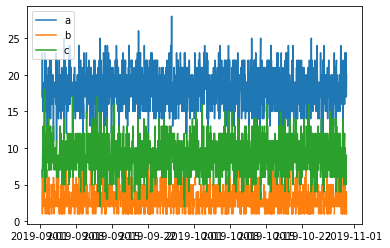

In [7]:
plt.plot(df_currated['unit_a'])
plt.plot(df_currated['unit_b'])
plt.plot(df_currated['unit_c'])
plt.legend(['a', 'b', 'c'])
plt.show()

## Replace NaN to 0

In [8]:
df_currated.fillna(0, inplace=True)

In [9]:
df_currated[df_currated['unit_a'].isnull()], df_currated[df_currated['unit_a'].isnull()], df_currated[df_currated['unit_a'].isnull()]

(Empty DataFrame
 Columns: [unit_a, unit_b, unit_c]
 Index: [],
 Empty DataFrame
 Columns: [unit_a, unit_b, unit_c]
 Index: [],
 Empty DataFrame
 Columns: [unit_a, unit_b, unit_c]
 Index: [])

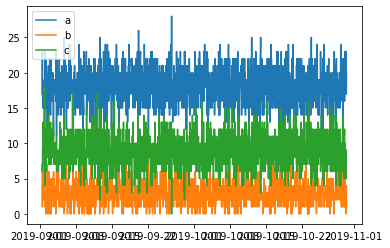

In [10]:
plt.plot(df_currated['unit_a'])
plt.plot(df_currated['unit_b'])
plt.plot(df_currated['unit_c'])
plt.legend(['a', 'b', 'c'])
plt.show()

## RRCF (Initial)

In [11]:
import numpy as np
X = df_currated.to_numpy()
n_points, n_vars = np.shape(X)
n_points, n_vars

(1419, 3)

In [12]:
np.isnan(X).any()

False

In [13]:
# Seed for Repeatebility
np.random.seed(0)

## RRCF Non-Stream

In [14]:
import rrcf

# Construct forest
forest = []

# Specify forest parameters
num_trees = 100
tree_size = int(n_points * 0.125)
sample_size_range = (n_points // tree_size, tree_size)

while len(forest) < num_trees:
    # Select random subsets of points uniformly from point set
    ixs = np.random.choice(n_points, size=sample_size_range, replace=False)
    
    # Add sampled trees to forest
    trees = [rrcf.RCTree(X[ix], index_labels=ix) for ix in ixs]
    forest.extend(trees)

In [15]:
# Compute average CoDisp
avg_codisp = pd.Series(0.0, index=np.arange(n_points))
index = np.zeros(n_points)
for tree in forest:
    codisp = pd.Series({leaf : tree.codisp(leaf) for leaf in tree.leaves})
    avg_codisp[codisp.index] += codisp
    np.add.at(index, codisp.index.values, 1)
avg_codisp /= index

In [16]:
anom_idx = (avg_codisp > avg_codisp.quantile(0.99))
anom_idx = anom_idx[anom_idx].index
anom_idx

Int64Index([11, 67, 76, 142, 257, 268, 270, 333, 449, 495, 603, 744, 866, 1048,
            1244],
           dtype='int64')

In [17]:
X[avg_codisp > avg_codisp.quantile(0.99)]

array([[ 9.,  3., 18.],
       [11.,  8., 11.],
       [14.,  9.,  7.],
       [10.,  3., 17.],
       [10.,  3., 17.],
       [15.,  0., 15.],
       [25.,  3.,  2.],
       [11.,  3., 16.],
       [26.,  1.,  3.],
       [11.,  9., 10.],
       [28.,  2.,  0.],
       [11.,  3., 16.],
       [15.,  0., 15.],
       [13.,  1., 16.],
       [14.,  0., 16.]])

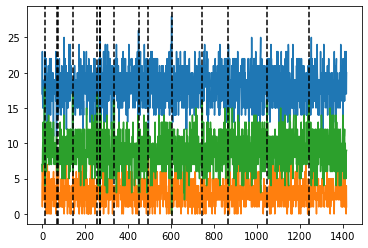

In [18]:
plt.plot(X)
for xc in anom_idx:
    plt.axvline(x=xc, color='k', linestyle='--')
plt.show()

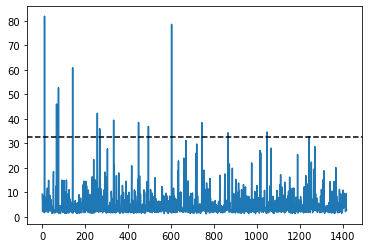

In [19]:
plt.plot(avg_codisp)
plt.axhline(avg_codisp.quantile(0.99), color='k', linestyle='--')
plt.show()

## RRCF Stream

In [20]:
# Set tree parameters
num_trees = 100
n_shingle = 8 # lenght of the shingle, using 24 hour as one point
shingle_size = n_shingle # * n_vars
tree_size = int(n_points * 0.8) # number of points in the tree for fifo

# Create a forest of empty trees
forest = []
for _ in range(num_trees):
    tree = rrcf.RCTree()
    forest.append(tree)

In [21]:
# # Use the "shingle" generator to create rolling window
points = rrcf.shingle(X, size=n_shingle)
points = [point.T.flatten() for point in points]

In [22]:
# Create a dict to store anomaly score of each point
avg_codisp = pd.Series(0.0, index=np.arange(len(points)))

# For each shingle...
for index, point in enumerate(points):
    # For each tree in the forest...
    for tree in forest:
        # If tree is above permitted size...
        if len(tree.leaves) > tree_size:
            # Drop the oldest point (FIFO)
            tree.forget_point(index - tree_size)
        # Insert the new point into the tree
        tree.insert_point(point, index=index)
        # Compute codisp on the new point...
        new_codisp = tree.codisp(index)
        # And take the average over all trees
        avg_codisp[index] += new_codisp / num_trees

In [28]:
anom_idx = (avg_codisp > avg_codisp.quantile(0.99))
anom_idx = anom_idx[anom_idx].index
anom_idx

Int64Index([596, 597, 598, 599, 600, 601, 602, 603, 976, 1018, 1147, 1168,
            1254, 1312, 1313],
           dtype='int64')

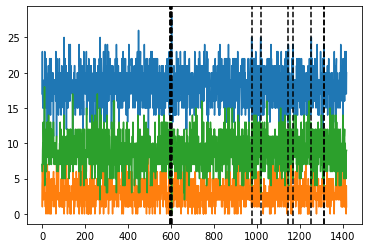

In [25]:
plt.plot(X)
for xc in anom_idx:
    plt.axvline(x=xc, color='k', linestyle='--')
plt.show()

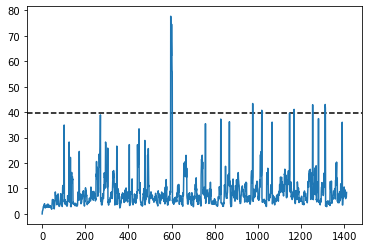

In [27]:
plt.axhline(avg_codisp.quantile(0.99), color='k', linestyle='--')
plt.plot(avg_codisp)